# Using the ReactomeGSA package

This tutorial is based on the vignette created by Johannes Griss (2021-09-23) https://www.bioconductor.org/packages/release/bioc/vignettes/ReactomeGSA/inst/doc/using-reactomegsa.html


## Introduction

The ReactomeGSA package is a client to the web-based Reactome Analysis System. Essentially, it performs a gene set analysis using the latest version of the Reactome pathway database as a backend.

The main advantages of using the Reactome Analysis System are:
*   Simultaneous analysis and visualization of different types of ’omics data
*   Support for direct comparison across different species
* Directly linked with Reactome’s powerful pathway browser producing publication-ready figures of your gene set analysis

## Citation
To cite this package, use

Griss J. ReactomeGSA, https://github.com/reactome/ReactomeGSA (2019)

Griss, J., Viteri, G., Sidiropoulos, K., Nguyen, V., Fabregat, A., & Hermjakob, H. (2020). ReactomeGSA - Efficient Multi-Omics Comparative Pathway Analysis. Molecular & cellular proteomics : MCP, 19(12), 2115–2125. https://doi.org/10.1074/mcp.TIR120.002155



## Using Google Colab

To use the notebook directly with R:
Open your favorite browser.
Go to this URL: https://colab.research.google.com/#create=true&language=r, or this short URL https://colab.to/r
After accessing the URL, you will be taken to a new Colab notebook with the default title Unitled.ipynb.
At first glance, there is no difference between notebooks with Python and R runtimes. However, if we go to the “Runtime” settings, and select “Change runtime type”, we will get a dialog confirming that we are already in R runtime.
Above referenced from https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497

## Installation

The ReactomeGSA package can be directly installed from Bioconductor:


In [9]:
# Test if Bioconductor's BioManager is installed 
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
   BiocManager::install(version = "3.14")
}


if (!require(ReactomeGSA))
  BiocManager::install("ReactomeGSA")

In [10]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("ReactomeGSA")



'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'ReactomeGSA'”


For more information, see https://bioconductor.org/install/.

The installation of ReactomeGSA.data takes approximately 30 minutes, since it requires the installation of many dependencies. This step should be run prior to the hands-on part of the workshop.

In [11]:
## Install the ReactomeGSA.data package
if (!require(ReactomeGSA.data))
  BiocManager::install("ReactomeGSA.data")


Loading required package: ReactomeGSA.data

Loading required package: limma

Loading required package: edgeR

Loading required package: Seurat

Attaching SeuratObject



## Getting available methods

The Reactome Analysis System will be continuously updated. Before starting your analysis it is therefore a good approach to check which methods are available.

This can simply be done by using:

In [12]:
library(ReactomeGSA)

available_methods <- get_reactome_methods(print_methods = FALSE, return_result = TRUE)

# only show the names of the available methods
available_methods$name
#> [1] "PADOG"  "Camera" "ssGSEA"



[1] "PADOG"  "Camera" "ssGSEA"

To get more information about a specific method, set `print_details` to `TRUE` and specify the `method`:

In [13]:
padog_params <- available_methods$parameters[available_methods$name == "PADOG"][[1]]

paste0(padog_params$name, " (", padog_params$type, ", ", padog_params$default, ")")

[1] "use_interactors (bool, False)"             
 [2] "include_disease_pathways (bool, True)"     
 [3] "max_missing_values (float, 0.5)"           
 [4] "create_reactome_visualization (bool, True)"
 [5] "create_reports (bool, False)"              
 [6] "email (string, )"                          
 [7] "reactome_server (string, production)"      
 [8] "sample_groups (string, )"                  
 [9] "discrete_norm_function (string, TMM)"      
[10] "continuous_norm_function (string, none)"

## Creating an analysis request

To start a gene set analysis, you first have to create an analysis request. This is a simple S4 class that takes care of submitting multiple datasets simultaneously to the analysis system.

When creating the request object, you already have to specify the analysis method you want to use:



In [14]:
# Create a new request object using 'Camera' for the gene set analysis
my_request <-ReactomeAnalysisRequest(method = "Camera")

my_request
#> ReactomeAnalysisRequestObject
#>   Method = Camera
#>   No request data stored
#> ReactomeAnalysisRequest

ReactomeAnalysisRequestObject
  Method = Camera
  No request data stored

## Setting parameters
To get a list of supported parameters for each method, use the ``get_reactome_methods`` function (see above).

Parameters are simply set using the ``set_parameters`` function:

In [15]:
# set the maximum number of allowed missing values to 50%
my_request <- set_parameters( request = my_request, 
                              max_missing_values = 0.5,                            
                              create_reactome_visualization = TRUE)

my_request
#> ReactomeAnalysisRequestObject
#>   Method = Camera
#>   Parameters:
#>   - max_missing_values: 0.5
#>   Datasets: none
#> ReactomeAnalysisRequest

ReactomeAnalysisRequestObject
  Method = Camera
  Parameters:
  - max_missing_values: 0.5
  - create_reactome_visualization: TRUE
  Datasets: none

Multiple parameters can by set simulataneously by simply adding more name-value pairs to the function call.

## Adding datasets

One analysis request can contain multiple datasets. This can be used to, for example, visualize the results of an RNA-seq and Proteomics experiment (of the same / similar samples) side by side:


In [16]:
library(ReactomeGSA.data)
data("griss_melanoma_proteomics")


This is a limma `EList` object with the sample data already added


In [17]:
class(griss_melanoma_proteomics)
#> [1] "EList"
#> attr(,"package")
#> [1] "limma"
head(griss_melanoma_proteomics$samples)
#>                patient.id condition cell.type
#> M-D MOCK PBMCB         P3      MOCK     PBMCB
#> M-D MCM PBMCB          P3       MCM     PBMCB
#> M-K MOCK PBMCB         P4      MOCK     PBMCB
#> M-K MCM PBMCB          P4       MCM     PBMCB
#> P-A MOCK PBMCB         P1      MOCK     PBMCB
#> P-A MCM PBMCB          P1       MCM     PBMCB

[1] "EList"
attr(,"package")
[1] "limma"

,patient.id,condition,cell.type
,<fct>,<fct>,<fct>
M-D MOCK PBMCB,P3,MOCK,PBMCB
M-D MCM PBMCB,P3,MCM,PBMCB
M-K MOCK PBMCB,P4,MOCK,PBMCB
M-K MCM PBMCB,P4,MCM,PBMCB
P-A MOCK PBMCB,P1,MOCK,PBMCB
P-A MCM PBMCB,P1,MCM,PBMCB


This is an example of how to import the proteomics dataset from text tab-delimited file:

In [18]:
data_dir <- "."

# Create object for storing proteomics data
griss_melanoma_proteomics <- new("EList")

# Read protein abundances 
protein_abundances <- read.table( file.path(data_dir, "Proteomics", "protein_abundances.tab"), 
                                  sep="\t", stringsAsFactors = FALSE, header=TRUE, check.names	=FALSE ) 

## Set the first column as the row names and then remove it 
rownames( protein_abundances ) <- protein_abundances[,"uniprot_acc"]
protein_abundances <- protein_abundances[,setdiff(colnames(protein_abundances), "uniprot_acc")]

griss_melanoma_proteomics$E <- protein_abundances

#  Read list of samples
proteomic_samples <-  read.table( file.path(data_dir, "Proteomics", "list_of_samples.tab"), 
                                  sep="\t", stringsAsFactors = FALSE, header=TRUE, check.names	=FALSE ) 
   
rownames( proteomic_samples ) <- proteomic_samples[,"samples.id"]
proteomic_samples <- proteomic_samples[,setdiff(colnames(proteomic_samples), "samples.id")]
  
griss_melanoma_proteomics$samples <- proteomic_samples

# Read list of proteins
list_of_proteins <-  read.table( file.path(data_dir, "Proteomics", "list_of_proteins.tab"), 
                                  sep="\t", stringsAsFactors = FALSE, header=TRUE, check.names	=FALSE ) 
   
rownames( list_of_proteins ) <- list_of_proteins[,"uniprot_acc"]
list_of_proteins <- list_of_proteins[,setdiff(colnames(list_of_proteins), "uniprot_acc")]

griss_melanoma_proteomics$genes <- list_of_proteins

The dataset can now simply be added to the request using the `add_dataset` function:


In [19]:
my_request <- add_dataset(request = my_request, 
                          expression_values = griss_melanoma_proteomics, 
                          name = "Proteomics", 
                          type = "proteomics_int",
                          comparison_factor = "condition", 
                          comparison_group_1 = "MOCK", 
                          comparison_group_2 = "MCM",
                          additional_factors = c("cell.type", "patient.id"))
my_request

#> ReactomeAnalysisRequestObject
#>   Method = Camera
#>   Parameters:
#>   - max_missing_values: 0.5
#>   Datasets:
#>   - Proteomics (proteomics_int)
#>     No parameters set.
#> ReactomeAnalysisRequest

ReactomeAnalysisRequestObject
  Method = Camera
  Parameters:
  - max_missing_values: 0.5
  - create_reactome_visualization: TRUE
  Datasets:
  - Proteomics (proteomics_int)
    No parameters set.

Several datasets (of the same experiment) can be added to one request. This RNA-seq data is stored as an `edgeR DGEList` object:

In [20]:
data("griss_melanoma_rnaseq")

# only keep genes with >= 100 reads in total
total_reads <- rowSums(griss_melanoma_rnaseq$counts)
griss_melanoma_rnaseq <- griss_melanoma_rnaseq[total_reads >= 100, ]

# this is a edgeR DGEList object
class(griss_melanoma_rnaseq)
#> [1] "DGEList"
#> attr(,"package")
#> [1] "edgeR"
head(griss_melanoma_rnaseq$samples)
#>        group lib.size norm.factors patient cell_type treatment
#> 195-13  MOCK 29907534    1.0629977      P1      TIBC      MOCK
#> 195-14   MCM 26397322    0.9927768      P1      TIBC       MCM
#> 195-19  MOCK 18194834    1.0077827      P2     PBMCB      MOCK
#> 195-20   MCM 24282215    1.0041410      P2     PBMCB       MCM
#> 197-11  MOCK 22628117    0.9522869      P1     PBMCB      MOCK
#> 197-12   MCM 23319849    1.0115732      P1     PBMCB       MCM


[1] "DGEList"
attr(,"package")
[1] "edgeR"

,group,lib.size,norm.factors,patient,cell_type,treatment
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<fct>
195-13,MOCK,29907534,1.0629977,P1,TIBC,MOCK
195-14,MCM,26397322,0.9927768,P1,TIBC,MCM
195-19,MOCK,18194834,1.0077827,P2,PBMCB,MOCK
195-20,MCM,24282215,1.0041410,P2,PBMCB,MCM
197-11,MOCK,22628117,0.9522869,P1,PBMCB,MOCK
197-12,MCM,23319849,1.0115732,P1,PBMCB,MCM


This is an example of how to upload the RNA-Seq data from text tab-delimited file:

In [21]:

data_dir <- "."

# Create object for storing proteomics data
griss_melanoma_rnaseq <- new("DGEList")

# Read transcript abundances 
transcript_abundances <- read.table( file.path(data_dir, "RNA-Seq", "transcript_abundances.tab"), 
                                  sep="\t", stringsAsFactors = FALSE, header=TRUE, check.names	=FALSE ) 

# Set the ensembl_gene_id column as the row names and then remove the column   
rownames( transcript_abundances ) <- transcript_abundances[,"ensembl_gene_id"]
transcript_abundances <- transcript_abundances[,setdiff(colnames(transcript_abundances), "ensembl_gene_id")]

griss_melanoma_rnaseq$counts <- transcript_abundances


# Read list of samples
rnaseq_samples <- read.table( file.path(data_dir, "RNA-Seq", "list_of_samples.tab"), 
                                  sep="\t", stringsAsFactors = FALSE, header=TRUE, check.names	=FALSE ) 

rownames( rnaseq_samples ) <- rnaseq_samples[,"samples.id"]
rnaseq_samples <- rnaseq_samples[,setdiff(colnames(rnaseq_samples), "samples.id")]

griss_melanoma_rnaseq$samples <- rnaseq_samples


Again, the dataset can simply be added using `add_dataset`. Here, we added an additional parameter to the `add_dataset` call. Such additional parameters are treated as additional dataset-level parameters.



In [22]:
## -----------------------------------------------------------------------------
# add the dataset
my_request <- add_dataset(request = my_request, 
                          expression_values = griss_melanoma_rnaseq, 
                          name = "RNA-seq", 
                          type = "rnaseq_counts",
                          comparison_factor = "treatment", 
                          comparison_group_1 = "MOCK", 
                          comparison_group_2 = "MCM",
                          additional_factors = c("cell_type", "patient"),
                          # This adds the dataset-level parameter 'discrete_norm_function' to the request
                          discrete_norm_function = "TMM")
#> Converting expression data to string... (This may take a moment)
#> Conversion complete                          
my_request
#> ReactomeAnalysisRequestObject
#>   Method = Camera
#>   Parameters:
#>   - max_missing_values: 0.5
#>   Datasets:
#>   - Proteomics (proteomics_int)
#>     No parameters set.
#>   - RNA-seq (rnaseq_counts)
#>     discrete_norm_function: TMM
#> ReactomeAnalysisRequest

Converting expression data to string... (This may take a moment)

Conversion complete



ReactomeAnalysisRequestObject
  Method = Camera
  Parameters:
  - max_missing_values: 0.5
  - create_reactome_visualization: TRUE
  Datasets:
  - Proteomics (proteomics_int)
    No parameters set.
  - RNA-seq (rnaseq_counts)
    discrete_norm_function: TMM

## Sample annotations

Datasets can be passed as limma `EList`, edgeR `DGEList`, any implementation of the Bioconductor `ExpressionSet`, or simply a `data.frame`.

For the first three, sample annotations are simply read from the respective slot. When supplying the expression values as a `data.frame`, the `sample_data` parameter has to be set using a `data.frame` where each row represents one sample and each column one proptery. If the the `sample_data` option is set while providing the expression data as an `EList`, `DGEList`, or `ExpressionSet`, the data in `sample_data` will be used instead of the sample annotations in the expression data object.

## Name

Each dataset has to have a name. This can be anything but has to be unique within one analysis request.

## Type

The ReactomeAnalysisSystem supports different types of ’omics data. To get a list of supported types, use the `get_reactome_data_types` function:

In [23]:
get_reactome_data_types()
#> rnaseq_counts:
#>    RNA-seq (raw counts) 
#>    Raw RNA-seq based read counts per gene (recommended). 
#> rnaseq_norm:
#>    RNA-seq (normalized) 
#>    log2 transformed, normalized RNA-seq based read counts per gene (f.e. RPKM, TPM) 
#> proteomics_int:
#>    Proteomics (intensity) 
#>    Intensity-based quantitative proteomics data (for example, iTRAQ/TMT or intensity-based label-free quantitation). Values must be log2 transformed. 
#> proteomics_sc:
#>    Proteomics (spectral counts) 
#>    Raw spectral-counts of label-free proteomics experiments 
#> microarray_norm:
#>    Microarray (normalized) 
#>    Normalized and log2 transformed microarray-based gene expression values.

rnaseq_counts:
   RNA-seq (raw counts) 
   Raw RNA-seq based read counts per gene (recommended). 
rnaseq_norm:
   RNA-seq (normalized) 
   log2 transformed, normalized RNA-seq based read counts per gene (f.e. RPKM, TPM) 
proteomics_int:
   Proteomics (intensity) 
   Intensity-based quantitative proteomics data (for example, iTRAQ/TMT or intensity-based label-free quantitation). Values must be log2 transformed. 
proteomics_sc:
   Proteomics (spectral counts) 
   Raw spectral-counts of label-free proteomics experiments 
microarray_norm:
   Microarray (normalized) 
   Normalized and log2 transformed microarray-based gene expression values. 


## Defining the experimental design
Defining the experimental design for a `ReactomeAnalysisRequest` is very simple. Basically, it only takes three parameters:

* `comparison_factor`: Name of the property within the sample data to use
* `comparison_group_1`: The first group to compare
* `comparison_group_2`: The second group to compare

The value set in `comparison_factor` must match a column name in the sample data (either the slot in an `Elist`, `DGEList`, or `ExpressionSet` object or in the sample_data parameter).

Additionally, it is possible to define blocking factors. These are supported by all methods that rely on linear models in the backend. Some methods though might simply ignore this parameter. For more information on whether a method supports blocking factors, please use `get_reactome_methods`.

Blocking factors can simply be set `additional_factors` to a vector of names. These should again reference properties (or columns) in the sample data.

## Submitting the request

Once the `ReactomeAnalysisRequest` is created, the complete analysis can be run using `perform_reactome_analysis`:

In [24]:
result <- perform_reactome_analysis(request = my_request, compress = F)
#> Submitting request to Reactome API...
#> Reactome Analysis submitted succesfully
#> Converting dataset Proteomics...
#> Mapping identifiers...
#> Performing gene set analysis using Camera
#> Analysing dataset 'Proteomics' using Camera
#> Analysing dataset 'RNA-seq' using Camera
#> Creating REACTOME visualization
#> Retrieving result...

Submitting request to Reactome API...

Reactome Analysis submitted succesfully

Converting dataset RNA-seq...

Performing gene set analysis using Camera

Analysing dataset 'Proteomics' using Camera

Analysing dataset 'RNA-seq' using Camera

Creating REACTOME visualization

Retrieving result...



## Investigating the result
The result object is a `ReactomeAnalysisResult` S4 class with several helper functions to access the data.

To retrieve the names of all available results (generally one per dataset), use the `names` function:

In [25]:
names(result)
#> [1] "Proteomics" "RNA-seq"

[1] "Proteomics" "RNA-seq"

For every dataset, different result types may be available. These can be shown using the `result_types` function:

In [26]:
result_types(result)
#> [1] "pathways"     "fold_changes"

[1] "pathways"     "fold_changes"

The `Camera` analysis method returns two types of results, pathway-level data and gene- / protein-level fold changes.

A specific result can be retrieved using the `get_result` method:

In [27]:
## -----------------------------------------------------------------------------
# retrieve the fold-change data for the proteomics dataset
proteomics_fc <- get_result(result, type = "fold_changes", name = "Proteomics")
head(proteomics_fc)
#>   Identifier      logFC   AveExpr         t      P.Value    adj.P.Val         B
#> 1     Q14526  0.4937650 -3.346909 14.518726 1.522007e-10 8.270584e-07 13.998275
#> 2     Q6VY07  0.2981411 -3.330347 13.561998 4.137121e-10 1.124056e-06 13.140156
#> 3     P07093  1.7950301 -3.648968 12.283282 1.736483e-09 3.145349e-06 11.876210
#> 4     P10124  1.0758634 -3.436961 10.322552 2.023758e-08 2.749275e-05  9.635221
#> 5     P55210  0.5018522 -3.347932  9.510506 6.223343e-08 6.763529e-05  8.582997
#> 6     O43683 -0.4754083 -3.345551 -9.362094 7.699368e-08 6.973061e-05  8.382004

,Identifier,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Q14526,0.4937650,-3.346909,14.518874,1.521544e-10,8.268071e-07,13.998563
2,Q6VY07,0.2981411,-3.330347,13.562228,4.135505e-10,1.123617e-06,13.140519
3,P07093,1.7950301,-3.648968,12.283351,1.736118e-09,3.144688e-06,11.876414
4,P10124,1.0758634,-3.436961,10.322614,2.023379e-08,2.748760e-05,9.635399
5,P55210,0.5018522,-3.347932,9.510577,6.222128e-08,6.762209e-05,8.583182
6,O43683,-0.4754083,-3.345551,-9.362165,7.697867e-08,6.971702e-05,8.382188


Additionally, it is possible to directly merge the pathway level data for all result sets using the pathways function:

In [28]:
combined_pathways <- pathways(result)

head(combined_pathways)
#>                                                                                                                              Name
#> R-HSA-163200  Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.
#> R-HSA-1428517                                                      The citric acid (TCA) cycle and respiratory electron transport
#> R-HSA-611105                                                                                       Respiratory electron transport
#> R-HSA-6799198                                                                                                Complex I biogenesis
#> R-HSA-72649                                                                              Translation initiation complex formation
#> R-HSA-72662                Activation of the mRNA upon binding of the cap-binding complex and eIFs, and subsequent binding to 43S
#>               Direction.Proteomics FDR.Proteomics PValue.Proteomics
#> R-HSA-163200                    Up   2.155315e-14      1.028790e-17
#> R-HSA-1428517                   Up   2.667615e-14      2.546649e-17
#> R-HSA-611105                    Up   6.088648e-14      8.718828e-17
#> R-HSA-6799198                   Up   4.101238e-12      7.830526e-15
#> R-HSA-72649                   Down   2.850602e-08      6.803347e-11
#> R-HSA-72662                   Down   5.706180e-08      1.634228e-10
#>               NGenes.Proteomics av_foldchange.Proteomics sig.Proteomics
#> R-HSA-163200                107               0.13980458           TRUE
#> R-HSA-1428517               147               0.12760898           TRUE
#> R-HSA-611105                 93               0.14055433           TRUE
#> R-HSA-6799198                55               0.15261118           TRUE
#> R-HSA-72649                  57              -0.09502561           TRUE
#> R-HSA-72662                  58              -0.09089517           TRUE
#>               Direction.RNA-seq  FDR.RNA-seq PValue.RNA-seq NGenes.RNA-seq
#> R-HSA-163200               Down 1.775933e-05   5.952428e-07            123
#> R-HSA-1428517              Down 3.332796e-05   1.272599e-06            167
#> R-HSA-611105               Down 2.321641e-04   1.265274e-05            102
#> R-HSA-6799198              Down 3.036956e-03   2.473889e-04             57
#> R-HSA-72649                Down 1.323048e-01   2.986260e-02             58
#> R-HSA-72662                Down 1.724015e-01   4.213121e-02             59
#>               av_foldchange.RNA-seq sig.RNA-seq
#> R-HSA-163200            -0.19129352        TRUE
#> R-HSA-1428517           -0.17226313        TRUE
#> R-HSA-611105            -0.18071563        TRUE
#> R-HSA-6799198           -0.17510280        TRUE
#> R-HSA-72649             -0.10382630       FALSE
#> R-HSA-72662             -0.07783433       FALSE

,Name,Direction.Proteomics,FDR.Proteomics,PValue.Proteomics,NGenes.Proteomics,av_foldchange.Proteomics,sig.Proteomics,Direction.RNA-seq,FDR.RNA-seq,PValue.RNA-seq,NGenes.RNA-seq,av_foldchange.RNA-seq,sig.RNA-seq
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
R-HSA-163200,"Respiratory electron transport, ATP synthesis by chemiosmotic coupling, and heat production by uncoupling proteins.",Up,2.198759e-14,1.049527e-17,107,0.13980458,TRUE,Down,1.893878e-05,6.439024e-07,123,-0.19043836,TRUE
R-HSA-1428517,The citric acid (TCA) cycle and respiratory electron transport,Up,2.722700e-14,2.599236e-17,147,0.12760898,TRUE,Down,3.568535e-05,1.380096e-06,167,-0.17141114,TRUE
R-HSA-611105,Respiratory electron transport,Up,6.203505e-14,8.883300e-17,93,0.14055433,TRUE,Down,2.409052e-04,1.355961e-05,102,-0.17986034,TRUE
R-HSA-6799198,Complex I biogenesis,Up,4.165506e-12,7.953233e-15,55,0.15261118,TRUE,Down,3.057173e-03,2.598532e-04,57,-0.17425393,TRUE
R-HSA-72649,Translation initiation complex formation,Down,2.851448e-08,6.805364e-11,57,-0.09502561,TRUE,Down,1.362003e-01,3.110793e-02,58,-0.10297851,FALSE
R-HSA-72662,"Activation of the mRNA upon binding of the cap-binding complex and eIFs, and subsequent binding to 43S",Down,5.706954e-08,1.634450e-10,58,-0.09089517,TRUE,Down,1.776027e-01,4.377796e-02,59,-0.07698596,FALSE


In [29]:
# reactome_links: Displays / retrieves the URLs to the available visualizations in Reactome’s pathway browser.
# open_reactome: Opens the specified Reactome visualization in the system’s default browser

In [30]:
reactome_links(result)

1: Gene Set Analysis Summary
   Overview over all submitted datasets showing significantly and non-significantly up- and down- regulated pathways
   URL = https://www.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMTExMDkyMzExMDRfMzYyODI%3D


In [35]:
open_reactome(result)

Opening https://www.reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS=MjAyMTExMDkyMzExMDRfMzYyODI%3D in the default browser...



ERROR: Error in utils::browseURL(url = url): 'browser' must be a non-empty character string


## Visualising results
The ReactomeGSA package includes several basic plotting functions to visualise the pathway results. For comparative gene set analysis like the one presented here, two functions are available: `plot_correlations` and `plot_volcano`.

`plot_correlations` can be used to quickly assess how similar two datasets are on the pathway level:

Comparing 1 vs 2

Warning message:
“Removed 264 rows containing missing values (geom_point).”


[[1]]


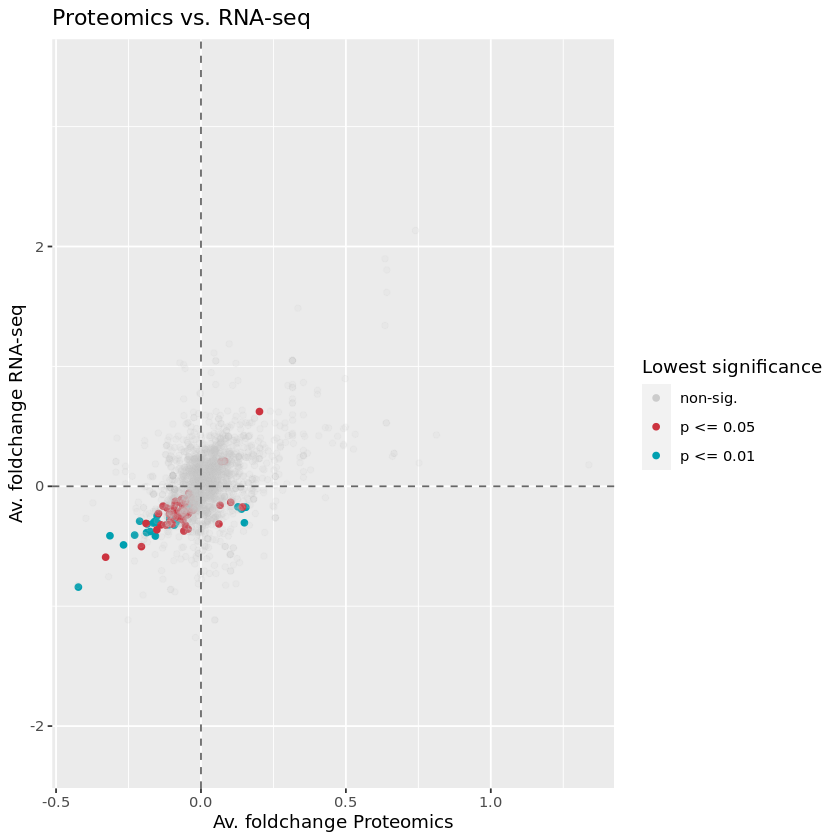

In [32]:
plot_correlations(result)
#> Comparing 1 vs 2
#> [[1]]
#> Warning: Removed 264 rows containing missing values (geom_point).

Individual datasets can further be visualised using volcano plots of the pathway data:

In [ ]:
plot_volcano(result, 2)

## Heatmap showing enriched pathways in transcriptomic and proteomic datasets

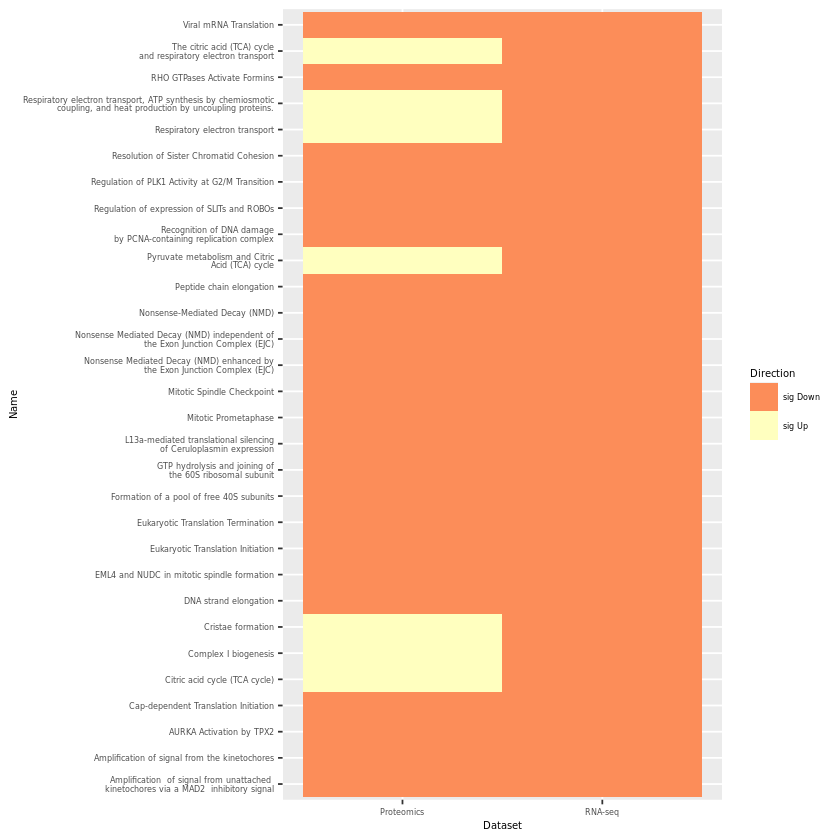

In [33]:
plot_heatmap(result) +
  # reduce text size to create a better HTML rendering
  ggplot2::theme(text = ggplot2::element_text(size = 6))


## Heatmap for all pathways with "Interleukin" in their name for transcriptomic and proteomic datasets

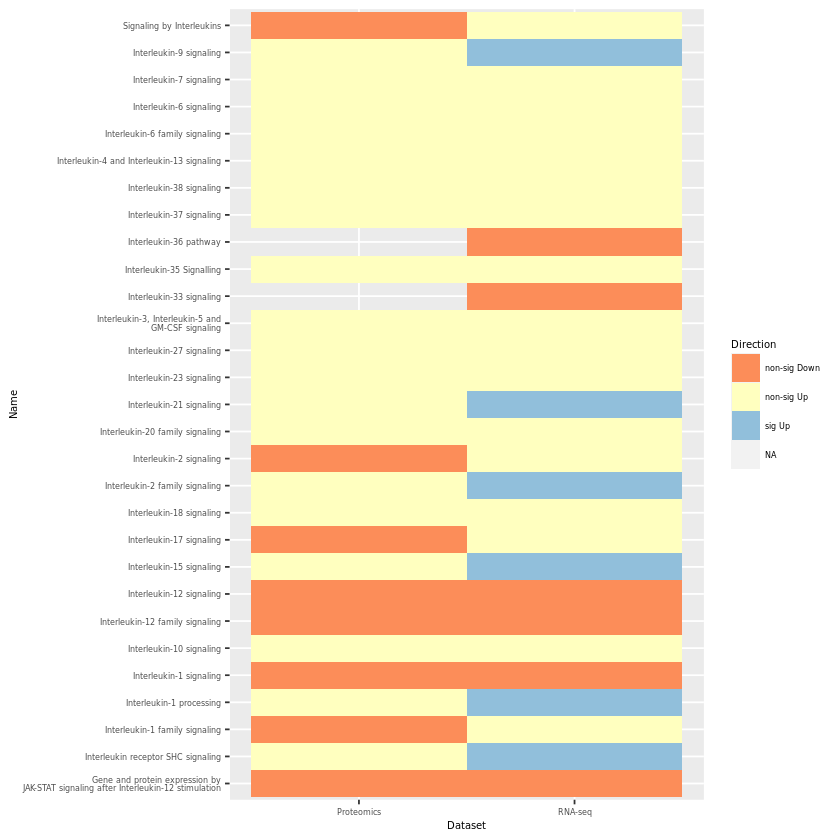

In [34]:

# get the data ready to plot with ggplot2
plot_data <- plot_heatmap(result, return_data = TRUE)

# select the pathways of interest - here all pathways
# with "Interleukin" in their name
interleukin_pathways <- grepl("Interleukin", plot_data$Name)

interesting_data <- plot_data[interleukin_pathways, ]

ggplot2::ggplot(interesting_data, ggplot2::aes(x = dataset, y = Name, fill = direction)) +
  ggplot2::geom_tile() +
  ggplot2::scale_fill_brewer(palette = "RdYlBu") +
  ggplot2::labs(x = "Dataset", fill = "Direction") +
  ggplot2::theme(text = ggplot2::element_text(size = 6))


## Additional Information
The following hyperlink provides a tutorial created by the Reactome team that demonstrates how to extract and analyse transcriptomics data from The Cancer Genome Atlas (TCGA) database. Please visit if you would like to learn more. https://github.com/reactome/ReactomeGSA-tutorials/blob/master/notebooks/TCGA_B_Cell_Analysis.ipynb


## Session Info

In [ ]:
sessionInfo()
#> R version 4.1.1 (2021-08-10)
#> Platform: x86_64-pc-linux-gnu (64-bit)
#> Running under: Ubuntu 20.04.3 LTS
#> 
#> Matrix products: default
#> BLAS:   /home/biocbuild/bbs-3.13-bioc/R/lib/libRblas.so
#> LAPACK: /home/biocbuild/bbs-3.13-bioc/R/lib/libRlapack.so
#> 
#> locale:
#>  [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
#>  [3] LC_TIME=en_GB              LC_COLLATE=C              
#>  [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
#>  [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
#>  [9] LC_ADDRESS=C               LC_TELEPHONE=C            
#> [11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       
#> 
#> attached base packages:
#> [1] stats     graphics  grDevices utils     datasets  methods   base     
#> 
#> other attached packages:
#> [1] ReactomeGSA.data_1.6.0 SeuratObject_4.0.2     Seurat_4.0.4          
#> [4] edgeR_3.34.1           limma_3.48.3           ReactomeGSA_1.6.1     
#> 
#> loaded via a namespace (and not attached):
#>   [1] Rtsne_0.15            colorspace_2.0-2      deldir_0.2-10        
#>   [4] ellipsis_0.3.2        ggridges_0.5.3        spatstat.data_2.1-0  
#>   [7] farver_2.1.0          leiden_0.3.9          listenv_0.8.0        
#>  [10] ggrepel_0.9.1         fansi_0.5.0           codetools_0.2-18     
#>  [13] splines_4.1.1         knitr_1.34            polyclip_1.10-0      
#>  [16] jsonlite_1.7.2        ica_1.0-2             cluster_2.1.2        
#>  [19] png_0.1-7             uwot_0.1.10           shiny_1.7.0          
#>  [22] sctransform_0.3.2     spatstat.sparse_2.0-0 BiocManager_1.30.16  
#>  [25] compiler_4.1.1        httr_1.4.2            assertthat_0.2.1     
#>  [28] Matrix_1.3-4          fastmap_1.1.0         lazyeval_0.2.2       
#>  [31] later_1.3.0           prettyunits_1.1.1     htmltools_0.5.2      
#>  [34] tools_4.1.1           igraph_1.2.6          gtable_0.3.0         
#>  [37] glue_1.4.2            RANN_2.6.1            reshape2_1.4.4       
#>  [40] dplyr_1.0.7           Rcpp_1.0.7            scattermore_0.7      
#>  [43] jquerylib_0.1.4       vctrs_0.3.8           nlme_3.1-153         
#>  [46] lmtest_0.9-38         xfun_0.26             stringr_1.4.0        
#>  [49] globals_0.14.0        mime_0.11             miniUI_0.1.1.1       
#>  [52] lifecycle_1.0.0       irlba_2.3.3           gtools_3.9.2         
#>  [55] goftest_1.2-2         future_1.22.1         MASS_7.3-54          
#>  [58] zoo_1.8-9             scales_1.1.1          spatstat.core_2.3-0  
#>  [61] hms_1.1.0             promises_1.2.0.1      spatstat.utils_2.2-0 
#>  [64] parallel_4.1.1        RColorBrewer_1.1-2    curl_4.3.2           
#>  [67] yaml_2.2.1            reticulate_1.22       pbapply_1.5-0        
#>  [70] gridExtra_2.3         ggplot2_3.3.5         sass_0.4.0           
#>  [73] rpart_4.1-15          stringi_1.7.4         highr_0.9            
#>  [76] caTools_1.18.2        rlang_0.4.11          pkgconfig_2.0.3      
#>  [79] matrixStats_0.61.0    bitops_1.0-7          evaluate_0.14        
#>  [82] lattice_0.20-45       ROCR_1.0-11           purrr_0.3.4          
#>  [85] tensor_1.5            labeling_0.4.2        patchwork_1.1.1      
#>  [88] htmlwidgets_1.5.4     cowplot_1.1.1         tidyselect_1.1.1     
#>  [91] parallelly_1.28.1     RcppAnnoy_0.0.19      plyr_1.8.6           
#>  [94] magrittr_2.0.1        R6_2.5.1              gplots_3.1.1         
#>  [97] generics_0.1.0        DBI_1.1.1             mgcv_1.8-36          
#> [100] pillar_1.6.2          fitdistrplus_1.1-5    survival_3.2-13      
#> [103] abind_1.4-5           tibble_3.1.4          future.apply_1.8.1   
#> [106] crayon_1.4.1          KernSmooth_2.23-20    utf8_1.2.2           
#> [109] spatstat.geom_2.2-2   plotly_4.9.4.1        rmarkdown_2.11       
#> [112] progress_1.2.2        locfit_1.5-9.4        grid_4.1.1           
#> [115] data.table_1.14.0     digest_0.6.27         xtable_1.8-4         
#> [118] tidyr_1.1.3           httpuv_1.6.3          munsell_0.5.0        
#> [121] viridisLite_0.4.0     bslib_0.3.0